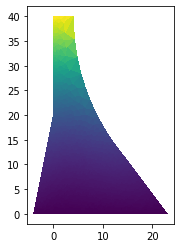

Deplacement en (0,40): [0.00309074 0.00022182]


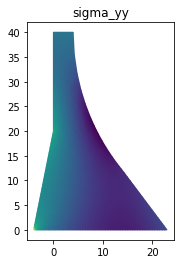

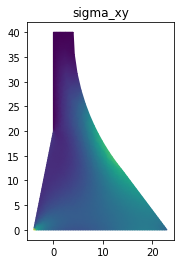

Contrainte en (-4,0): [0.43550639 0.84015827 0.84015827 1.5452058 ]
Rx(y=0) via contraintes: -7.872121063829414
Ry(y=0) via contraintes: 12.48889308588453
Mz/O(y=0) via contraintes: 172.8054660254949
Rx(y=0) via travail: -7.848000000096919
Ry(y=0) via travail: 12.535936298799605
Mz/O(y=0) via travail: 172.69938227720974
Norme du résidu: 1.1151204272763373e-12
0.002866757084281998
0.002866757084281998
0.002866757084281998
0.002866757084281998
0.002866757084281998


In [5]:
# -*- coding: utf-8 -*-
"""
Barrage du Ternay (calcul élastique linéaire, HPP)

Created on Wed Oct 11 12:46:22 2017
@author: Jeremy Bleyer, Xavier Chateau
Ecole des Ponts ParisTech, Laboratoire Navier (ENPC,IFSTTAR,CNRS UMR 8205)
@email: jeremy.bleyer@enpc.fr, xavier.chateau@enpc.fr
"""
from dolfin import *
import subprocess
import matplotlib.pyplot as plt

# Unités : longueurs en m
#          efforts en MN, contraintes en MPa


# masse volumique béton
rhob = Constant(2.5e3)
# masse volumique eau
rhow = Constant(1e3)
# accélération de la pesanteur
g = Constant(9.81e-6)
# vecteur forces volumiques
rhoF = rhob*g*Constant((0, -1.))

# Pression de l'eau
Pw = Expression("rho*g*(H-x[1])", rho=rhow, g=g, H=40., degree=1)

# propriétés élastiques du béton
E = Constant(30e3)
nu = Constant(0.25)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)

## MAILLAGE
# nom du fichier .geo
fname = "Ternay"
# appel de Gmsh, génération du fichier .msh (ancien format "msh2")
subprocess.call(["gmsh", "-2", fname+".geo", "-format", "msh2"])
# appel de dolfin-convert pour conversion en .xml 
# (on peut aussi passer par meshio cf. https://fenicsproject.discourse.group/t/transitioning-from-mesh-xml-to-mesh-xdmf-from-dolfin-convert-to-meshio/412)
subprocess.call(["dolfin-convert", fname+".msh", fname+".xml"])

## Lecture du maillage généré
mesh = Mesh(fname+".xml")
# On récupère également les physical regions
subdomains = MeshFunction("size_t", mesh, fname+"_physical_region.xml")
# ainsi que les facet regions
boundaries = MeshFunction("size_t", mesh, fname+"_facet_region.xml")
# Et on génère les normales aux facets pour l'application de la pression
n = FacetNormal(mesh)
# élément d'intégration sur le volume
dx = Measure("dx")
# élément d'intégration sur le bord du domaine
ds = Measure("ds",subdomain_data=boundaries)

# Définition de l'espace d'interpolation pour le déplacement
V = VectorFunctionSpace(mesh,"CG",degree=2)
# Définition de fonctions tests (champs de vitesse virtuels)
u_ = TestFunction(V)
v = TrialFunction(V)
# fonction où l'on va stocker la solution
u = Function(V, name="Deplacement")

# Fonction utiles à l'écriture du problème
def eps(w):
    return sym(grad(w))
def sigma(w):
    # loi de comportement élastique linéaire isotrope (état initial naturel)
    return lmbda*tr(eps(w))*Identity(2) + 2*mu*eps(w)

# Définition du travail virtuel de déformation
Wdef = inner(sigma(v), eps(u_))*dx
# Définition du travail des efforts extérieurs
Wext = dot(rhoF, u_)*dx + dot(-Pw*n, u_)*ds(1)
#

# Définition des conditions aux limites sur la surface "2" (y=0)
bc = DirichletBC(V, Constant((0, 0)), boundaries, 2)

# Résolution du problème
solve(Wdef == Wext, u, bc)

# Tracé de la déformée
plot(u, mode = "displacement")
plt.show()

# Evaluation du déplacement en x=0 y=H
print("Deplacement en (0,40):", u(0, 40))

# Posttraitement des contraintes (projetées sur un espace continu linéaire/élement)
Vsig = TensorFunctionSpace(mesh, "CG", degree=1)
sig = Function(Vsig, name="Contraintes")
sig.assign(project(sigma(u), Vsig))
# tracé de la contrainte sigma_{yy}
plot(sig[1, 1], mode="color", title="sigma_yy")
plt.show()
# tracé de la contrainte sigma_{xy}
plot(sig[0, 1], mode="color", title="sigma_xy")
plt.show()
# évaluation de sigma en x=L,y=0
print("Contrainte en (-4,0):", sig(-4, 0))

# Sauvegarde de la solution au format VTK (pour Paraview)
u_file = File("Ternay/xi.pvd")
u_file << u
sig_file = File("Ternay/sig.pvd")
sig_file << sig

# ou dans un seul fichier au format XDMF (pour Paraview également)
ffile = XDMFFile("Ternay/results.xdmf")
ffile.write(u, 0)
ffile.write(sig, 0)

## QUELQUES COMPLEMENTS
# Calcul de l'effort vertical résultant en y=0 via les contraintes
print("Rx(y=0) via contraintes:", assemble(-sig[1, 0]*ds(2)))
# Calcul de l'effort horizontal résultant en y=0
print("Ry(y=0) via contraintes:", assemble(-sig[1, 1]*ds(2)))
# Calcul du moment/O autour de z en y=0
print("Mz/O(y=0) via contraintes:", assemble(-Expression("x[0]", degree=1)*sig[1, 1]*ds(2)))

# Calcul de la résultante au pied du barrage via le travail des efforts intérieurs
bc_pied_x = DirichletBC(V, Constant((1., 0.)), boundaries, 2)
bc_pied_y = DirichletBC(V, Constant((0., 1.)), boundaries, 2)
bc_pied_m = DirichletBC(V, Expression(("0.", "x[0]"), degree=1), boundaries, 2)
v_x = Function(V)
bc_pied_x.apply(v_x.vector())
v_y = Function(V)
bc_pied_y.apply(v_y.vector())
v_m = Function(V)
bc_pied_m.apply(v_m.vector())
Wreac = action(Wdef, u) - Wext
print("Rx(y=0) via travail:",assemble(action(Wreac,v_x)))
print("Ry(y=0) via travail:",assemble(action(Wreac,v_y)))
print("Mz/O(y=0) via travail:",assemble(action(Wreac,v_m)))

# Assemblage de la matrice de rigidité et du vecteur des forces nodales
K, F = assemble_system(Wdef, Wext, bc)
# vecteur solution
U = u.vector()
# On verifie que KU = F
res = K*U - F
print("Norme du résidu:", res.norm("l2"))

# Calcul de l'énergie mécanique (F^T,U)/2.
# 1ere solution : méthode "inner" de F ou de U
print(0.5*F.inner(U))
print(0.5*U.inner(F))
# 2eme solution : on convertit F et U en Numpy array puis
U_numpy = U.get_local()
F_numpy = F.get_local()
print(0.5*F_numpy.dot(U_numpy))
# ou encore
import numpy as np
print(0.5*np.dot(F_numpy.T,U_numpy))
# 3ème solution : on évalue le travail virtuel des efforts extérieurs pour la solution
print(assemble(action(0.5*Wext,u)))
